# Intro
This notebook depicts the results of our ICLR workshop submission. We attempt training on token embeddings and test to see if similar embeddings cary explanatory signal for classificaiton. The hypothesis is that we've encoded positional information sufficiently that we can now learn on the concatenated embeddings themselves.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from embed_patches import *

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
USE_GPU = True

print("GPU detected?", torch.cuda.is_available())
if USE_GPU and torch.cuda.is_available():
	device = torch.device('cuda')
	print("\nNote: gpu available & selected!")
else:
	device = torch.device('cpu')
	print("\nNote: gpu NOT available!")

GPU detected? False

Note: gpu NOT available!


# 

# 1. Sequence-level Dataset Construction
- Running inference with trained $f_\theta$ to construct $\mathbf{Z}$ embedded sequences, for both train and test
- We also show a bit of the process before we dive into full-sequence training. We get an idea of what clustering over token embeddings looks like before the conversion to $\mathbf{C}$ sequence mosaics


Get train set stats/info

In [3]:
patch_dir = "/home/data/tinycam/train/train.hdf5"
label_dict_path = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
image_names = print_X_names(label_dict_path)
train_dim_dict = gather_Z_dims(patch_dir, image_names)

Gathering dimensions...
done!


In [4]:
i_max = 0
j_max = 0
for v in train_dim_dict.values():
    if v[0] > i_max:
        i_max = v[0]
    if v[1] > j_max:
        j_max = v[1]

print("max sizes are:", i_max, j_max)

max sizes are: 102 108


Get test set stats/info

In [5]:
import pandas as pd
ref_path = "/home/data/tinycam/test/cam16-eval/csnaftp_gdrive-16/reference.csv"
ref_df = pd.read_csv(ref_path, header=None, names=["id", "class", "meta1", "meta2"])
ref_df.head()

,id,class,meta1,meta2
0,test_001,Tumor,IDC,Macro
1,test_002,Tumor,ILC,Macro
2,test_003,Normal,DCIS,None
3,test_004,Tumor,IDC,Micro
4,test_005,Normal,DCIS,None


In [6]:
test_classes = [1 if el=="Tumor" else 0 for el in ref_df["class"]]
test_label_dict = dict(zip(ref_df["id"], test_classes))

In [7]:
from utils import deserialize
custom_test_dict_path = "/home/data/tinycam/test/cam16-eval/my_data/cam16_test_dim_dict.obj"
test_dims = deserialize(custom_test_dict_path)
# print(test_dims)

gt_path = "/home/data/tinycam/test/cam16-eval/csnaftp_gdrive-16/lesion_annotations"
gt_files = os.listdir(gt_path)

image_names = []
test_dim_dict = {}
for key in test_dims.keys():
    im_id = key.split(".tif")[0]
    image_names.append(im_id)
    test_dim_dict[im_id] = (test_dims[key][3][1], test_dims[key][3][0]) # swap dims

In [8]:
from utils import serialize
label_dict_path_test = "/home/codex_analysis/codex-analysis/code/outputs/test-cam-cam16-224-background-labeldict.obj"
utils.serialize(test_label_dict, label_dict_path_test)

In [9]:
i_max = 0
j_max = 0
for v in test_dim_dict.values():
    if v[0] > i_max:
        i_max = v[0]
    if v[1] > j_max:
        j_max = v[1]

print("max sizes are:", i_max, j_max)

max sizes are: 123 118


*Note these values above:* we want to pad our images to all be the same size for any downstream learning. Say 124 x 124 for the padding. Let's now set up $f_\theta$.

In [10]:
from models import ResNet18 
model = ResNet18(n_classes=2, in_channels=3, z_dim=128, supervised=False, no_relu=False, loss_type='triplet', tile_size=224, activation='relu')

In [11]:
chkpt = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background.sd"
checkpoint = torch.load(chkpt, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
prev_epoch = checkpoint['epoch']
loss = checkpoint['loss']

### Running inference
We want to process all patches in the training set and then attempt to learn from the concatenated embeddings

*Note:* This should take roughly 20min with 1 T4 GPU

In [12]:
patch_dir = "/home/data/tinycam/train/train.hdf5"
save_dir = "/home/data/tinycam/train/Zs"
# run below if needed/fresh directory:
#--------------------------------------
# construct_Zs_efficient(model, patch_dir, train_dim_dict, save_dir, device, scope="all")

We also perform this same inference step for the test set

In [13]:
patch_dir = "/home/data/tinycam/test/test.hdf5"
save_dir = "/home/data/tinycam/test/Zs"
# run below if needed/fresh directory:
#--------------------------------------
# construct_Zs_efficient(model, patch_dir, test_dim_dict, save_dir, device, scope="all", arm="test")

### Clustering and Example Mosaics
We create cluster labels for our embedded tokens $\mathbf{z}$, which in turn provides easy visualization of the full sequences. We perform the clustering procedure over a random sample of $\mathbf{z}$'s. 

In [14]:
from embed_patches import calculate_ideal_k
embed_dict_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
sse, sil = calculate_ideal_k(embed_dict_path, ks=list(range(2,21)))

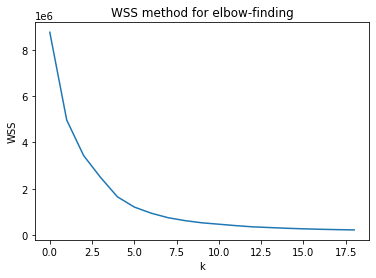

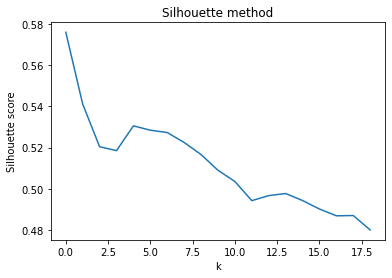

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sse)
plt.title("WSS method for elbow-finding")
plt.xlabel("k")
plt.ylabel("WSS")
plt.show()

plt.figure()
plt.plot(sil)
plt.title("Silhouette method")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.show()

A good choice of K from these metrics looks to be K=4,5,6

total embeds: 4440
collapsing from dim 128 --> 2


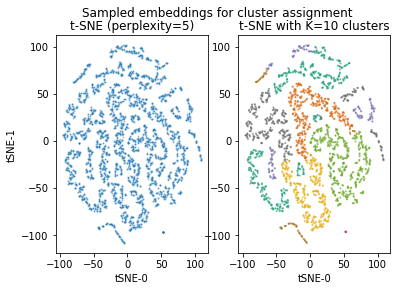

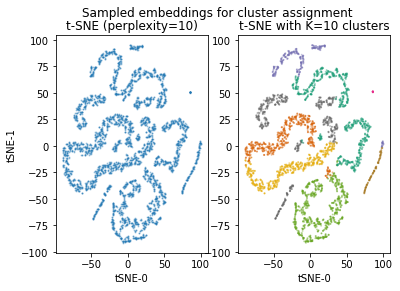

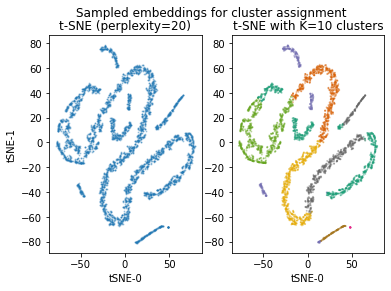

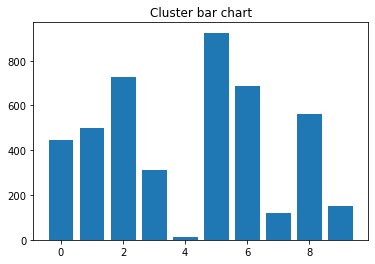

In [261]:
kmeans_model = fit_clustering(embed_dict_path, K=10)

Now let's take a look at example mosaics from the training set

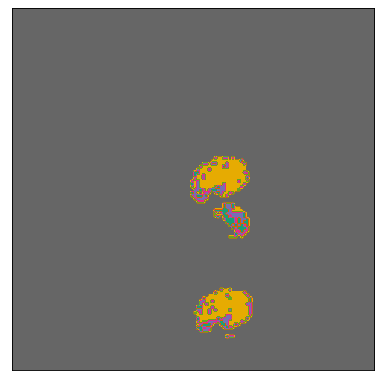

In [17]:
Z_path = "/home/data/tinycam/train/Zs/Z-tumor_045.npy"
visualize_Z(Z_path, kmeans_model)

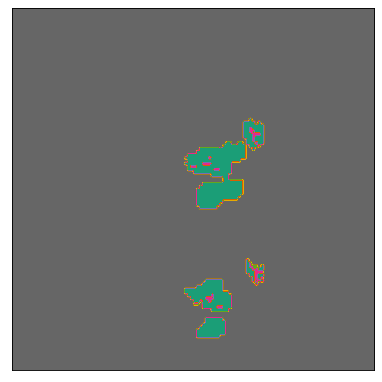

In [18]:
Z_path = "/home/data/tinycam/train/Zs/Z-normal_045.npy"
visualize_Z(Z_path, kmeans_model)

# 2. Cleaning up the test-set
Test set $\mathbf{Z}$'s likely have slide background patches that need removal. The training set was constructed with border trimmming since we wanted wanted to be careful of what SSL training saw — border trimming thus ensured solely tissue tokens/patches. On the test-set this stringent trimming was not implemented since we noticed tissue quite close to borders and we didn't want to lose it due to lenient filtration. There, we remove borders in post-processing with a full view of the embedding map, $\mathbf{Z}$. Below you see a binarized and flattened view (wrt to channel space of $\mathbf{Z}$). You'll notice that the first set of thumbnails contain white vert/horiz lines — these are the borders to wipe clean!

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from embed_patches import clean_Zs

In [20]:
Z_test_path = "/home/data/tinycam/test/Zs"
save_dir = "/home/data/tinycam/test/clean_Zs"
# run below if needed/fresh directory:
#--------------------------------------
# clean_Zs(Z_test_path, save_dir)

Check out some of the Zs to get a sense of cleanliness...

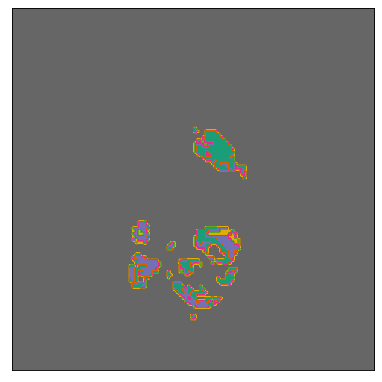

In [21]:
Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_006.npy"
visualize_Z(Z_path, kmeans_model)

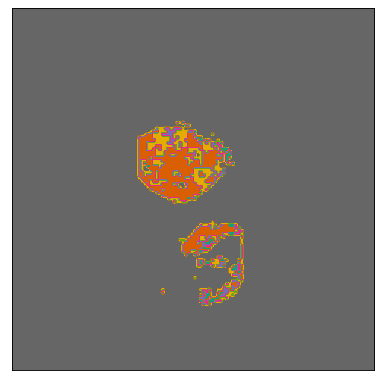

In [22]:
Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_010.npy"
visualize_Z(Z_path, kmeans_model)

# 3. Exploring Data and Salient Object Scale
We first need a complete view of the data. Let's first generate test set salient object masks (from provided XML files) at patch scale + load dictionary of test-set dimensions. Then we create:
- histogram of % salient objects
- historgram of image pixel space of original gigpixel dataset (H,W)
- histogram of % valid/foreground tokens per sequence

First we generate ground truth masks from XML files

In [23]:
from cam_process import computeEvaluationMaskXML_lowres
import numpy as np
import matplotlib.pyplot as plt

In [24]:
gt_path = "/home/data/tinycam/test/cam16-eval/csnaftp_gdrive-16/lesion_annotations"
gt_save_path = "/home/data/tinycam/test/gt_masks"
#-------rerun if needed: can take 30min-----------
# level, resolution = 5, None
# print("we have", len(os.listdir(gt_path)), "masks to generate!")
# for i, mask in enumerate(os.listdir(gt_path)):
#     id = mask.split(".xml")[0]
#     print("started processing mask", i, "| ID:", id)
#     og_dims = (test_dims[id + ".tif"][0][1], test_dims[id + ".tif"][0][0]) # swap dims
#     # og_dims = test_dims[id + ".tif"][0]
#     mask_np = computeEvaluationMaskXML_lowres(gt_path + "/" + mask, og_dims, resolution, level)
#     if mask_np is None:
#         break
#     np.save(gt_save_path + "/" + id + "_gt", mask_np)
#     print("finished processing mask", i, "| ID:", id)


You can view dimensions if desired

In [25]:
sods = []
sums = []
mask_names = []
for mask_name in os.listdir(gt_save_path):
    mask = np.load(gt_save_path + "/" + mask_name)
    mask_names.append(mask_name)
    summed = np.sum(mask)
    sums.append(summed)
    sods.append(summed / mask.size)

sodcount_dict = dict(zip(mask_names, sums))
# print(sodcount_dict)

In [26]:
Hs, Ws = [], []
for key in test_dims.keys():
    og_dims = test_dims[key][0]
    W, H = og_dims[0], og_dims[1]
    Hs.append(H)
    Ws.append(W)

In [27]:
percent_patches_0, percent_patches_1 = [], []
Z_path = "/home/data/tinycam/test/clean_Zs"
for key in test_dims.keys():
    patch_dims = test_dims[key][3]
    total = patch_dims[0] * patch_dims[1]
    
    im_id = key.split(".tif")[0]
    Z = np.load(Z_path + "/" + "Z-"+im_id+".npy")
    flatZ = np.sum(Z, axis=2) > 0
    valid = np.sum(flatZ)
    lab = test_label_dict[im_id]
    if lab == 0:
        percent_patches_0.append(valid/total)
    else:
        percent_patches_1.append(valid/total)

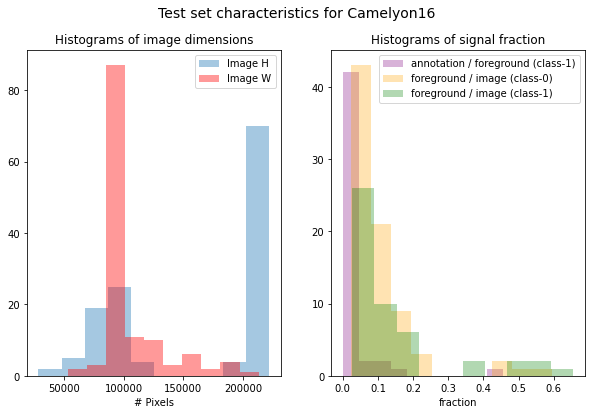

In [28]:
import seaborn as sns

plt.figure(figsize=(10,6))
plt.suptitle("Test set characteristics for Camelyon16", fontsize=14)
plt.subplot(1,2,1)
plt.title("Histograms of image dimensions", fontsize=12)
plt.hist(Hs, alpha=0.4, bins=10, label='Image H')
plt.hist(Ws, alpha=0.4, bins=10, label='Image W', color="red")
plt.xlabel("# Pixels")
plt.legend()
plt.subplot(1,2,2)
plt.title("Histograms of signal fraction", fontsize=12)
plt.hist(sods, alpha=0.3, bins=10, color="purple", label='annotation / foreground (class-1)')
plt.hist(percent_patches_0, alpha=0.3, bins=10, color="orange", label='foreground / image (class-0)')
plt.hist(percent_patches_1, alpha=0.3, bins=10, color="green", label='foreground / image (class-1)')
plt.xlabel("fraction")
plt.legend()
plt.show()

# 4. Shallow learner #1: Differential Expression-based analysis
- image TF-IDF with sliding windows
- class-level averages
- Log2FC and MannWhitney U test for independence

In [30]:
try:
    kmeans_models = utils.deserialize("kmeans_models_dict.obj")
except:
    kmeans_models = {}
print("K-means models cached (K):", list(kmeans_models.keys()))

try:
    tfidfs = utils.deserialize("tfidfs_dict.obj")
except:
    tfidfs = {}
print("tf-idf models cached (K,r):", list(tfidfs.keys()))
# tfidfs = {} # overwrite

K-means models cached (K): [25, 20, 30]
tf-idf models cached (K,r): [(30, 3)]


Run desired set of K,r

In [31]:
from embed_patches import class_tfidf
embed_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
Zs_path = "/home/data/tinycam/train/Zs"
label_dict_path = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict = utils.deserialize(label_dict_path)

for K in [30]:
    if K in kmeans_models.keys():
        kmeans_model = kmeans_models[K]
        print("Using existing k-means model")
    else:
        print("Fitting new k-means model...")
        kmeans_model = fit_clustering(embed_path, K=K, alg="kmeans_euc", verbosity="none")
        kmeans_models[K] = kmeans_model
    for r in [3]:
        if (K,r) in tfidfs.keys():
            print("Using precomputed tfidf! skipping run for (K,r):", K, r)
            continue
        else:
            print("Calculating tfidf for (K,r):", K, r)
            class0_tfidf, class1_tfidf, pvals = class_tfidf(Zs_path, label_dict, kmeans_model, K, r)
            tfidfs[(K,r)] = [class0_tfidf, class1_tfidf, pvals]

Using existing k-means model
Using precomputed tfidf! skipping run for (K,r): 30 3


In [32]:
serialize(kmeans_models, "kmeans_models_dict.obj")
serialize(tfidfs, "tfidfs_dict.obj")

any nans for class0? False
any nans for class1? False
any nans for pvals? False
mean: -0.14968215448429048
min: -18.25564417736695
max: 16.079268488740194
number of + peaks > 1:  79
number of - peaks < -1: 77


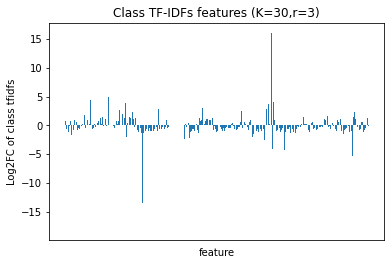

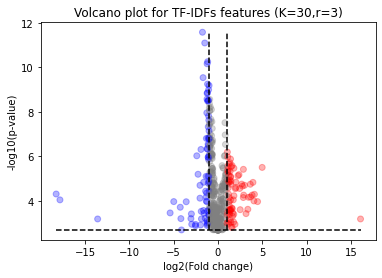

In [33]:
from embed_patches import diff_exp
log2fc, neglog10p, colors = diff_exp(tfidfs, K, r, tau=1.0, alpha=0.01)

In [34]:
significance_mask = [0 if c=="gray" else 1 for c in colors]
FI_significant = log2fc * np.array(significance_mask)

mask shape: (2800, 2688)
map shape:  (51, 49)
mask shape: (51, 49)


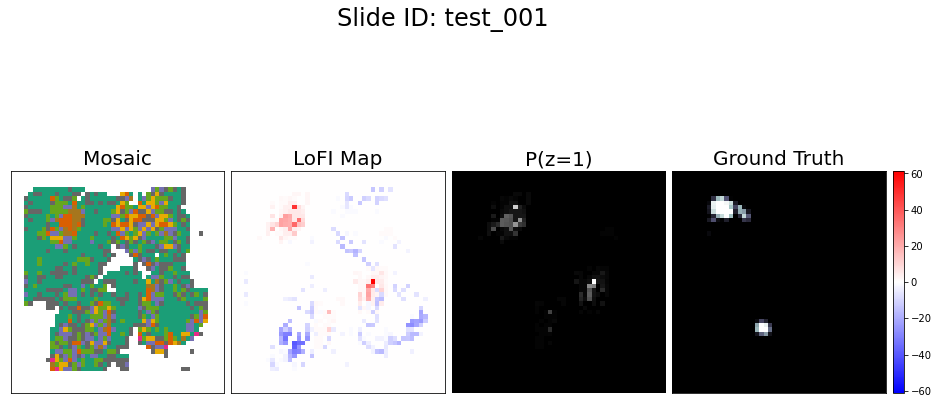

In [35]:
from embed_patches import lofi_map, sod_map_generator
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/test_crop_coords.obj")

Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_001.npy"
gt_path = "/home/data/tinycam/test/gt_masks/test_001_gt.npy"

K=30
r=3
hf = False

if r > 0:
    m = "coclusterbag"
else:
    m = "clusterbag"

# FI = log2fc
M = lofi_map(Z_path, kmeans_models[K], FI=FI_significant, mode=m, nbhd_size=r)
C_crop, zero_id, M_crop, normalized, mask = sod_map_generator(Z_path, M, kmeans_models[K], crop_dict, nbhd_size=r, mask_path=gt_path, highres_flag=hf)

### Now use this model to generate a full set of SOD masks

In [85]:
from embed_patches import generate_model_outputs
csv_save_path = "/home/data/tinycam/test/csv_outputs"
Zs_path = "/home/data/tinycam/test/clean_Zs"
gts_path = "/home/data/tinycam/test/gt_masks"

#--- toggle: takes 2min per model-----------
result_dict = generate_model_outputs(Zs_path, kmeans_models[K], FI_significant, m, r, crop_dict, csv_save_path, gts_path, test_label_dict)
# map_ys, accs_0_dict, accs_1_dict = generate_model_outputs(Zs_path, kmeans_models[K], FI_significant, m, r, crop_dict, csv_save_path, gts_path, test_label_dict)

In [86]:
for el in result_dict.items():
    print(el)

('mean_max_accs_0_valid', 0.9983312248199553)
('mean_max_accs_1_valid', 0.8469314263788226)
('mean_max_accs_valid', 0.9408227742492926)
('mean_accs_thresh_0_valid', array([0.80959557, 0.92615921, 0.95413311, 0.97049071, 0.98154908,
       0.98840344, 0.9917659 , 0.99374883, 0.99484925, 0.99582546,
       0.99833122]))
('mean_accs_thresh_1_valid', array([0.59396824, 0.69310557, 0.73829174, 0.76394922, 0.78657492,
       0.80179829, 0.8115544 , 0.8185337 , 0.82281675, 0.82692267,
       0.83042481]))
('mean_accs_thresh_valid', array([0.72769061, 0.83763496, 0.87214685, 0.89203696, 0.90748913,
       0.91752242, 0.92331347, 0.92719425, 0.92950357, 0.93166859,
       0.93455282]))
('mean_max_accs_0_so', None)
('mean_max_accs_1_so', 0.2587867599083766)
('mean_max_accs_so', None)
('mean_accs_thresh_0_so', None)
('mean_accs_thresh_1_so', array([0.25878676, 0.10841254, 0.05830386, 0.02856789, 0.01193463,
       0.00771111, 0.00496838, 0.00398654, 0.00327073, 0.0023756 ,
       0.        ]))
('

# 5. Shallow learner #2: Training on featurized Mosaics
This involves training shallow models $g_\beta$ over a multitude of hyperparameters. We have a few models we can train based on these Z data.

- ElasticNet on meanpool Z
- ElasticNet on maxpool Z
- ElasticNet on cat(meanpool, maxpool) Z
- ElasticNet on TF-IDF (with varying resolution)

In [87]:
Zs_path = "/home/data/tinycam/train/Zs"
n_normal, n_tumor = 0,0
for Z_file in os.listdir(Zs_path):
    no_ext = Z_file.split(".npy")[0]
    id_name = no_ext.split("-")[1]
    Z_class = id_name.split("_")[0]
    if Z_class == "normal":
        n_normal += 1
    else:
        n_tumor += 1

print("0 / 1 class cases in train:", n_normal, n_tumor)

0 / 1 class cases in train: 111 111


In [88]:
n_tumor, n_normal = 0,0
for val in test_label_dict.values():
    if val == 0:
        n_normal += 1
    else:
        n_tumor += 1

print("0 / 1 class cases in test:", n_normal, n_tumor)

0 / 1 class cases in test: 80 49


In [89]:
Zs_path_train = "/home/data/tinycam/train/Zs"
Zs_path_test = "/home/data/tinycam/test/clean_Zs"

In [92]:
from embed_patches import grid_search_elastic

embed_dict_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
label_dict_path_train = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict_path_test = "/home/codex_analysis/codex-analysis/code/outputs/test-cam-cam16-224-background-labeldict.obj"

model_strs, y_probs_all, ys_all, FIs, kmeans_models = grid_search_elastic(device, embed_dict_path, Zs_path_train, label_dict_path_train, Zs_path_test, label_dict_path_test)

Beginning shallow training on suite of 3 models
Fitting clusterer: kmeans_euc...
Training [ coclusterbag-K5-kmeans_euc-N4-L0.5 ] --> model # 1 / 3
	overall mean accuracy 0.4573643410852713
Fitting clusterer: kmeans_euc...
Training [ coclusterbag-K7-kmeans_euc-N4-L0.5 ] --> model # 2 / 3
	overall mean accuracy 0.5038759689922481
Fitting clusterer: kmeans_euc...
Training [ coclusterbag-K10-kmeans_euc-N4-L0.5 ] --> model # 3 / 3
	overall mean accuracy 0.5193798449612403


<Figure size 1080x720 with 0 Axes>

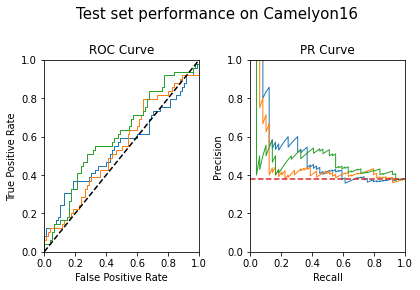

,model,aucs,auprcs
2,coclusterbag-K10-kmeans_euc-N4-L0.5,0.604592,0.481686
0,coclusterbag-K5-kmeans_euc-N4-L0.5,0.547959,0.500376
1,coclusterbag-K7-kmeans_euc-N4-L0.5,0.543112,0.458754


In [93]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(15,10))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Test set performance on Camelyon16", fontsize=15)
fig.tight_layout(pad=2.0)

ax1.set_title('ROC Curve')
aucs = []
for idx, y_prob in enumerate(y_probs_all):
    preds = y_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(ys_all[idx], preds)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, linewidth=1, label=model_strs[idx] + ' (AUC = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1],'k--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

ax2.set_title('PR Curve')
auprcs = []
for idx, y_prob in enumerate(y_probs_all):
    preds = y_prob[:,1]
    precision, recall, threshold = precision_recall_curve(ys_all[idx], preds)
    prc_auc = metrics.auc(recall, precision)
    auprcs.append(prc_auc)
    ax2.plot(recall, precision, linewidth=1, label=model_strs[idx] + ' (AUPRC = %0.2f)' % prc_auc)
no_skill = len(ys_all[idx][ys_all[idx]==1]) / len(ys_all[idx])
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')

plt.show()

d = {'model': model_strs, 'aucs': aucs, 'auprcs': auprcs}
df = pd.DataFrame(data=d).sort_values(by="aucs", ascending=False)
df

In [94]:
from embed_patches import lofi_map, sod_map_generator
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/test_crop_coords.obj")

mask shape: (3248, 3968)
map shape:  (59, 71)
mask shape: (59, 71)


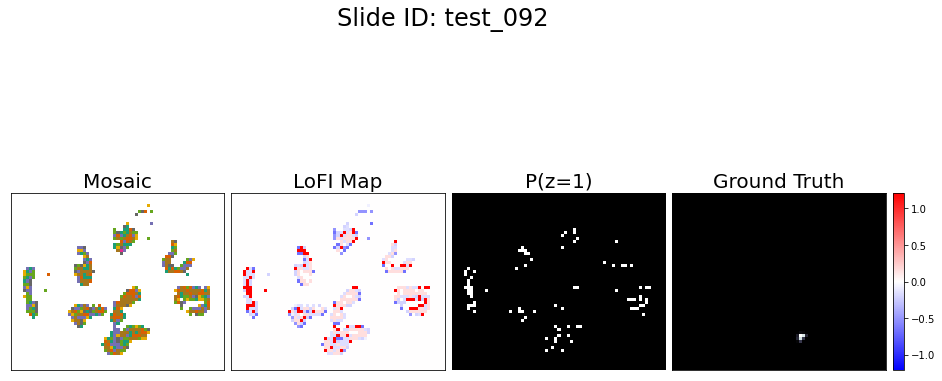

In [95]:
Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_092.npy"
gt_path = "/home/data/tinycam/test/gt_masks/test_092_gt.npy"

M = lofi_map(Z_path, kmeans_models["10-kmeans_euc"], FI=FIs[2], mode="clusterbag", nbhd_size=4)
C_crop, zero_id, M_crop, normalized, mask = sod_map_generator(Z_path, M, kmeans_model, crop_dict, nbhd_size=4, mask_path=gt_path)

# 6. Grid Search over all models!

In [122]:
from embed_patches import class_tfidf
from embed_patches import diff_exp
from embed_patches import generate_model_outputs
from embed_patches import eval_classifier

csv_save_path = "/home/data/tinycam/test/csv_outputs"
Zs_path_train = "/home/data/tinycam/train/Zs"
Zs_path_test = "/home/data/tinycam/test/clean_Zs"
gts_path = "/home/data/tinycam/test/gt_masks"
embed_path = "/home/codex_analysis/codex-analysis/code/train_sampled_inference_z_embeds.obj"
label_dict_path_train = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict_train = utils.deserialize(label_dict_path_train)
label_dict_path_test = "/home/codex_analysis/codex-analysis/code/outputs/test-cam-cam16-224-background-labeldict.obj"
label_dict_test = utils.deserialize(label_dict_path_test)
# test_label_dict


In [123]:
try:
    kmeans_models = utils.deserialize("kmeans_models_dict.obj")
except:
    kmeans_models = {}
print("K-means models cached (K):", list(kmeans_models.keys()))

try:
    tfidfs = utils.deserialize("tfidfs_dict.obj")
except:
    tfidfs = {}
print("tf-idf models cached (K,r):", list(tfidfs.keys()))

try:
    elastic = utils.deserialize("elastic_dict.obj")
except:
    elastic = {}
print("elasticNet models cached (K,r):", list(elastic.keys()))


# big doodad -- dict of all model runs and stats
try:
    all_results = utils.deserialize("all_results_lofi.obj")
except:
    all_results = {}
print("all models cached:", list(all_results.keys()))


K-means models cached (K): [25, 20, 30, 10]
tf-idf models cached (K,r): [(30, 3), (30, 1), (10, 0), (10, 1)]
elasticNet models cached (K,r): []
all models cached: []


In [124]:
Ks = [10,15,20,25,30]
rs = [0,1,2,4,8]
alphas = [0.01, 0.025, 0.05, 1e10]
taus = [0,1,2]

In [125]:
num_models = (len(Ks) * len(rs) * len(alphas) * len(taus)) + (len(Ks) * len(rs))
print("Expecting", num_models, "for this grid_search... get strapped in")
model_counter = 0
hf = False

for K in Ks:
    if K in kmeans_models.keys():
        kmeans_model = kmeans_models[K]
        print("Using existing k-means model")
    else:
        print("Fitting new k-means model...")
        kmeans_model = fit_clustering(embed_path, K=K, alg="kmeans_euc", verbosity="none")
        kmeans_models[K] = kmeans_model
        serialize(kmeans_models, "kmeans_models_dict.obj")

    for r in rs:
        if r > 0:
            m = "coclusterbag"
        else:
            m = "clusterbag"

        # ElasticNet
        #------------
        if (K,r) in elastic.keys():
            print("Using precomputed elasticNet! skipping run for (K,r):", K, r)
            FI, roc_auc, prc_auc = elastic[(K,r)]
        else:
            print("Training elasticNet for (K,r):", K, r)
            model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=0, max_iter=3000)
            model_trained, FI, y_probs, ys = train_on_Z(model, device, None, Zs_path_train, Zs_path_test, label_dict_path_train, label_dict_path_test, None, None, epochs=20, mode=m, kmeans_model=kmeans_models[K], nbhd_size=r)
            roc_auc, prc_auc = eval_classifier(ys, y_probs)
            elastic[(K,r)] = [FI, roc_auc, prc_auc]
            serialize(elastic, "elastic_dict.obj")

        model_str = "K"+str(K)+"-r"+str(r)+"-elastic"
        if model_str in all_results.keys():
            print("Using cached model:", model_str)
        else:
            result_dict = generate_model_outputs(Zs_path_test, kmeans_models[K], FI, m, r, crop_dict, csv_save_path, gts_path, label_dict_test)
            all_results[model_str] = result_dict
            serialize(all_results, "all_results_lofi.obj")
        model_counter += 1

        # DETok
        #-------
        if (K,r) in tfidfs.keys():
            print("Using precomputed tfidf! skipping run for (K,r):", K, r)
            class0_tfidf, class1_tfidf, pvals = tfidfs[(K,r)]
        else:
            print("Calculating tfidf for (K,r):", K, r)
            class0_tfidf, class1_tfidf, pvals = class_tfidf(Zs_path_train, label_dict_train, kmeans_models[K], K, r)
            tfidfs[(K,r)] = [class0_tfidf, class1_tfidf, pvals]
            serialize(tfidfs, "tfidfs_dict.obj")   
        
        for alpha in alphas:
            for tau in taus:
                log2fc, neglog10p, colors = diff_exp(tfidfs, K, r, tau=tau, alpha=alpha)        
                significance_mask = [0 if c=="gray" else 1 for c in colors]
                FI = log2fc * np.array(significance_mask)

                model_str = "K"+str(K)+"-r"+str(r)+"-DEtok"+"-a"+str(alpha)+"-t"+str(tau)
                if model_str in all_results.keys():
                    print("Using cached model:", model_str)
                else:
                    result_dict = generate_model_outputs(Zs_path_test, kmeans_models[K], FI, m, r, crop_dict, csv_save_path, gts_path, label_dict_test)
                    all_results[model_str] = result_dict
                    serialize(all_results, "all_results_lofi.obj")
                model_counter += 1   

        print("We've completed/stored", model_counter, "models")
        print("Another check for model count:", len(all_results.keys()))
        print("Models so far:", list(all_results.keys()))


Expecting 325 for this grid_search... get strapped in
Using existing k-means model
Training elasticNet for (K,r): 10 0
	overall mean accuracy 0.5581395348837209


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Using precomputed tfidf! skipping run for (K,r): 10 0


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 13 models
Another check for model count: 13
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2']
Training elasticNet for (K,r): 10 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


	overall mean accuracy 0.5503875968992248


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Using precomputed tfidf! skipping run for (K,r): 10 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 26 models
Another check for model count: 26
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2']
Training elasticNet for (K,r): 10 2
	overall mean accuracy 0.5271317829457365


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 10 2


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 39 models
Another check for model count: 39
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1', 

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 10 4


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 52 models
Another check for model count: 52
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1', 

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 65 models
Another check for model count: 65
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1', 

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 15 0


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 78 models
Another check for model count: 78
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1', 

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 15 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 91 models
Another check for model count: 91
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1', 

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 15 2
We've completed/stored 104 models
Another check for model count: 104
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 15 4


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 117 models
Another check for model count: 117
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 15 8


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 130 models
Another check for model count: 130
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 20 0


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 143 models
Another check for model count: 143
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 20 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 156 models
Another check for model count: 156
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 20 2
We've completed/stored 169 models
Another check for model count: 169
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 20 4


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 182 models
Another check for model count: 182
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 20 8


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 195 models
Another check for model count: 195
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 25 0


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 208 models
Another check for model count: 208
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 25 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 221 models
Another check for model count: 221
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 25 2


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 234 models
Another check for model count: 234
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 25 4


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 247 models
Another check for model count: 247
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 25 8


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 260 models
Another check for model count: 260
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 30 0


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


We've completed/stored 273 models
Another check for model count: 273
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Using precomputed tfidf! skipping run for (K,r): 30 1


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 286 models
Another check for model count: 286
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 30 2


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 299 models
Another check for model count: 299
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 30 4


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 312 models
Another check for model count: 312
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Calculating tfidf for (K,r): 30 8


/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/codex_analysis/codex-analysis/envs/lib/pyth

We've completed/stored 325 models
Another check for model count: 325
Models so far: ['K10-r0-elastic', 'K10-r0-DEtok-a0.01-t0', 'K10-r0-DEtok-a0.01-t1', 'K10-r0-DEtok-a0.01-t2', 'K10-r0-DEtok-a0.025-t0', 'K10-r0-DEtok-a0.025-t1', 'K10-r0-DEtok-a0.025-t2', 'K10-r0-DEtok-a0.05-t0', 'K10-r0-DEtok-a0.05-t1', 'K10-r0-DEtok-a0.05-t2', 'K10-r0-DEtok-a10000000000.0-t0', 'K10-r0-DEtok-a10000000000.0-t1', 'K10-r0-DEtok-a10000000000.0-t2', 'K10-r1-elastic', 'K10-r1-DEtok-a0.01-t0', 'K10-r1-DEtok-a0.01-t1', 'K10-r1-DEtok-a0.01-t2', 'K10-r1-DEtok-a0.025-t0', 'K10-r1-DEtok-a0.025-t1', 'K10-r1-DEtok-a0.025-t2', 'K10-r1-DEtok-a0.05-t0', 'K10-r1-DEtok-a0.05-t1', 'K10-r1-DEtok-a0.05-t2', 'K10-r1-DEtok-a10000000000.0-t0', 'K10-r1-DEtok-a10000000000.0-t1', 'K10-r1-DEtok-a10000000000.0-t2', 'K10-r2-elastic', 'K10-r2-DEtok-a0.01-t0', 'K10-r2-DEtok-a0.01-t1', 'K10-r2-DEtok-a0.01-t2', 'K10-r2-DEtok-a0.025-t0', 'K10-r2-DEtok-a0.025-t1', 'K10-r2-DEtok-a0.025-t2', 'K10-r2-DEtok-a0.05-t0', 'K10-r2-DEtok-a0.05-t1'

## Plot grid search results

In [227]:
print("We have", len(all_results.keys()), "shallow models to compare")

We have 325 shallow models to compare


resave dict

In [228]:
all_results_backup = deserialize("all_results_lofi.obj")
print("We have", len(all_results_backup.keys()), "shallow models to compare")

We have 325 shallow models to compare


In [262]:
serialize(all_results_backup, "all_results_lofi_backup.obj")

In [263]:
all_results_backup = deserialize("all_results_lofi_backup.obj")
print("We have", len(all_results_backup.keys()), "shallow models to compare")

We have 325 shallow models to compare


let's first collect:
- image-level AUROCs
- image-level AUPRCs 
- foreground-level mean-max Accs
- SO-level mean-max Accs

In [144]:
import numpy as np

search_plot_dict = {}
for model_str in all_results.keys():
    pieces = model_str.split("-")
    K, r, model_class = int(pieces[0].split("K")[1]), int(pieces[1].split("r")[1]), pieces[2]
    alpha = None
    tau = None
    if len(pieces) > 3:
        alpha = float(pieces[3].split("a")[1])
        tau = int(pieces[4].split("t")[1])
    key = (K,r,model_class,alpha,tau)
    model_vals = all_results[model_str]

    # classification
    roc_auc, prc_auc = 0.0, 0.0 # non-elastic
    if model_class == "elastic":
        _, roc_auc, prc_auc = elastic[(K,r)]
    roc_auc_fh, roc_auc_gs = model_vals["roc_auc_fh"], model_vals["roc_auc_gs"]
    prc_auc_fh, prc_auc_gs = model_vals["prc_auc_fh"], model_vals["prc_auc_gs"]
    max_auc_roc, max_auc_prc = np.max([roc_auc, roc_auc_fh, roc_auc_gs]), np.max([prc_auc, prc_auc_fh, prc_auc_gs]) 

    # sod
    acc_valid = model_vals["mean_max_accs_1_valid"]
    acc_so = model_vals["mean_max_accs_1_so"]

    vals = (max_auc_roc, max_auc_prc, acc_valid, acc_so)
    search_plot_dict[key] = vals
    

In [145]:
df_rows = [list(key) + list(val) for key,val in search_plot_dict.items()]

In [146]:
# make dict
import pandas as pd

cols = ["K", "r", "model_class", "a", "t", "auroc", "auprc", "acc_fg", "acc_so"]
results_df = pd.DataFrame.from_dict(df_rows, orient="columns")
results_df.columns = cols
results_df.head()

,K,r,model_class,a,t,auroc,auprc,acc_fg,acc_so
0,10,0,elastic,NaN,NaN,0.593367,0.650501,0.843741,0.179023
1,10,0,DEtok,0.010,0.0,0.622449,0.607017,0.858234,0.239454
2,10,0,DEtok,0.010,1.0,0.609184,0.469483,0.827451,0.017752
3,10,0,DEtok,0.010,2.0,0.500000,0.689922,0.830819,0.000000
4,10,0,DEtok,0.025,0.0,0.622449,0.607017,0.858234,0.239454


In [181]:
elastic_df = results_df.loc[results_df['model_class'] == "elastic"]
detok_df = results_df.loc[results_df['model_class'] == "DEtok"]

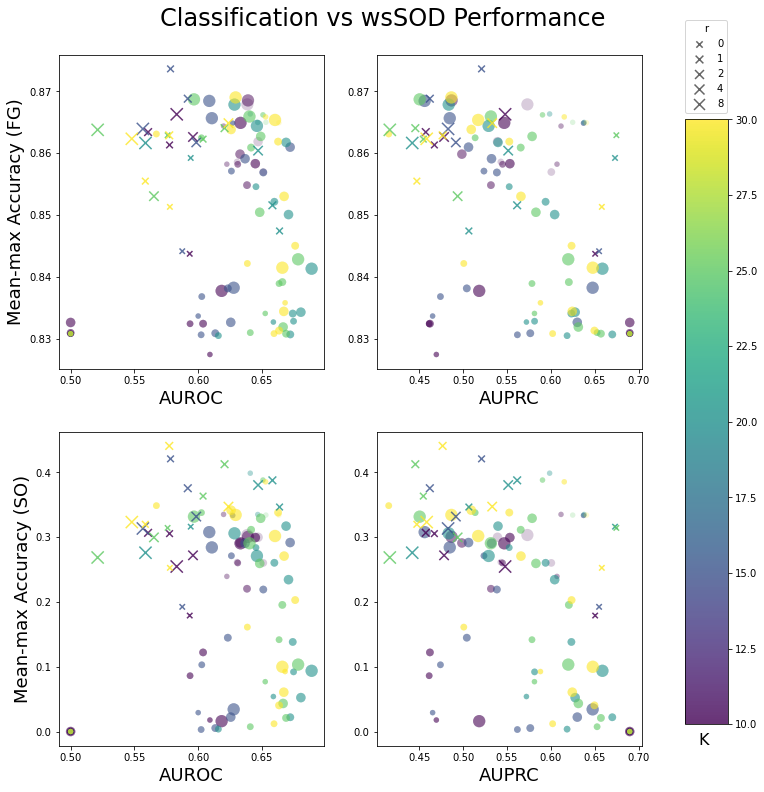

In [234]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Classification vs wsSOD Performance', fontsize=24)

SCALE = 15
c_detok = detok_df["K"]
s_detok = (np.array(detok_df["r"]) + 2) * SCALE
c_elastic = elastic_df["K"]
s_elastic = (np.array(elastic_df["r"]) + 2) * SCALE
ec="none"

axs[0,0].scatter(detok_df["auroc"], detok_df["acc_fg"], alpha=0.2, c=c_detok, edgecolors=ec, s=s_detok, marker="o")
axs[0,0].scatter(elastic_df["auroc"], elastic_df["acc_fg"], alpha=0.8, c=c_elastic, s=s_elastic, marker="x")
axs[0,0].set_xlabel('AUROC', fontsize=18)
axs[0,0].set_ylabel('Mean-max Accuracy (FG)', fontsize=18)

axs[0,1].scatter(detok_df["auprc"], detok_df["acc_fg"], alpha=0.2, c=c_detok, edgecolors=ec, s=s_detok, marker="o")
axs[0,1].scatter(elastic_df["auprc"], elastic_df["acc_fg"], alpha=0.8, c=c_elastic, s=s_elastic, marker="x")
axs[0,1].set_xlabel('AUPRC', fontsize=18)
# axs[0,1].set_ylabel('Mean-max Accuracy (FG)', fontsize=18)

axs[1,0].scatter(detok_df["auroc"], detok_df["acc_so"], alpha=0.2, c=c_detok, edgecolors=ec, s=s_detok, marker="o")
axs[1,0].scatter(elastic_df["auroc"], elastic_df["acc_so"], alpha=0.8, c=c_elastic, s=s_elastic, marker="x")
axs[1,0].set_xlabel('AUROC', fontsize=18)
axs[1,0].set_ylabel('Mean-max Accuracy (SO)', fontsize=18)

axs[1,1].scatter(detok_df["auprc"], detok_df["acc_so"], alpha=0.2, c=c_detok, edgecolors=ec, s=s_detok, marker="o")
axBR = axs[1,1].scatter(elastic_df["auprc"], elastic_df["acc_so"], alpha=0.8, c=c_elastic, s=s_elastic, marker="x")
axs[1,1].set_xlabel('AUPRC', fontsize=18)
# axs[1,1].set_ylabel('Mean-max Accuracy (SO)', fontsize=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axBR, cax=cbar_ax)
plt.text(0.32,9.3,"K", {"fontsize":16})

handles, labels = axBR.legend_elements(prop="sizes", alpha=0.6, num=6)     
labels = ["0", "1", "2", "4", "8"]
legend = plt.legend(handles, labels, loc=(0,1.01), title="r")

plt.subplots_adjust(top=0.925)
plt.show()


In [285]:
best_elastic_auroc = elastic_df.loc[elastic_df['auroc'].idxmax()]
best_elastic_auprc = elastic_df.loc[elastic_df['auprc'].idxmax()]
best_elastic_accso = elastic_df.loc[elastic_df['acc_so'].idxmax()]
best_elastic_accfg = elastic_df.loc[elastic_df['acc_fg'].idxmax()]

best_detok_auroc = detok_df.loc[detok_df['auroc'].idxmax()]
best_detok_auprc = detok_df.loc[detok_df['auprc'].idxmax()]
best_detok_accso = detok_df.loc[detok_df['acc_so'].idxmax()]
best_detok_accfg = detok_df.loc[detok_df['acc_fg'].idxmax()]

In [286]:
top_elastic_auroc = elastic_df.nlargest(3,"auroc")
top_elastic_auprc = elastic_df.nlargest(3,"auprc")
top_elastic_accso = elastic_df.nlargest(3,"acc_so")
top_elastic_accfg = elastic_df.nlargest(3,"acc_fg")
print(top_elastic_auroc)
print(top_elastic_auprc)
print(top_elastic_accso)
print(top_elastic_accfg)

      K  r model_class   a   t     auroc     auprc    acc_fg    acc_so
143  20  1     elastic NaN NaN  0.663776  0.506561  0.847433  0.346581
156  20  2     elastic NaN NaN  0.658163  0.561601  0.851585  0.387775
169  20  4     elastic NaN NaN  0.646939  0.551402  0.860426  0.380487
      K  r model_class   a   t     auroc     auprc    acc_fg    acc_so
195  25  0     elastic NaN NaN  0.576020  0.674670  0.862921  0.314337
130  20  0     elastic NaN NaN  0.594133  0.673155  0.859241  0.316241
260  30  0     elastic NaN NaN  0.577806  0.658112  0.851328  0.252683
      K  r model_class   a   t     auroc     auprc    acc_fg    acc_so
286  30  2     elastic NaN NaN  0.577296  0.476650  0.862900  0.440934
78   15  1     elastic NaN NaN  0.578316  0.521035  0.873649  0.420930
221  25  2     elastic NaN NaN  0.620663  0.445506  0.864059  0.412601
     K  r model_class   a   t     auroc     auprc    acc_fg    acc_so
78  15  1     elastic NaN NaN  0.578316  0.521035  0.873649  0.420930
91  15  

In [287]:
top_detok_auroc = detok_df.nlargest(3,"auroc")
top_detok_auprc = detok_df.nlargest(3,"auprc")
top_detok_accso = detok_df.nlargest(3,"acc_so")
top_detok_accfg = detok_df.nlargest(3,"acc_fg")
print(top_detok_auroc)
print(top_detok_auprc)
print(top_detok_accso)
print(top_detok_accfg)

      K  r model_class      a    t     auroc   auprc    acc_fg    acc_so
185  20  8       DEtok  0.010  2.0  0.688903  0.6588  0.841329  0.093722
188  20  8       DEtok  0.025  2.0  0.688903  0.6588  0.841329  0.093722
191  20  8       DEtok  0.050  2.0  0.688903  0.6588  0.841329  0.093722
    K  r model_class      a    t  auroc     auprc    acc_fg  acc_so
3  10  0       DEtok  0.010  2.0    0.5  0.689922  0.830819     0.0
6  10  0       DEtok  0.025  2.0    0.5  0.689922  0.830819     0.0
9  10  0       DEtok  0.050  2.0    0.5  0.689922  0.830819     0.0
      K  r model_class             a    t     auroc     auprc    acc_fg  \
137  20  0       DEtok  5.000000e-02  0.0  0.640816  0.598614  0.866357   
140  20  0       DEtok  1.000000e+10  0.0  0.640816  0.598614  0.866357   
199  25  0       DEtok  2.500000e-02  0.0  0.650765  0.590497  0.866212   

       acc_so  
137  0.398802  
140  0.398802  
199  0.388196  
      K  r model_class      a    t     auroc     auprc    acc_fg    acc

pareto optimal models

In [269]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [278]:
numbers_detok = detok_df[["auroc","auprc","acc_fg","acc_so"]].values
numbers_elastic = elastic_df[["auroc","auprc","acc_fg","acc_so"]].values
numbers_all = results_df[["auroc","auprc","acc_fg","acc_so"]].values

In [282]:
print(numbers_detok.shape)
print(numbers_elastic.shape)
print(numbers_all.shape)

(300, 4)
(25, 4)
(325, 4)


In [279]:
iseff_detok = is_pareto_efficient_dumb(numbers_detok)
iseff_elastic = is_pareto_efficient_dumb(numbers_elastic)
iseff_all = is_pareto_efficient_dumb(numbers_all)

In [280]:
paretto_all = results_df[pd.Series(iseff_all).values]
paretto_all

,K,r,model_class,a,t,auroc,auprc,acc_fg,acc_so
0,10,0,elastic,NaN,NaN,0.593367,0.650501,0.843741,0.179023
13,10,1,elastic,NaN,NaN,0.577551,0.467246,0.861343,0.305514
52,10,8,elastic,NaN,NaN,0.583163,0.547890,0.866302,0.254727
65,15,0,elastic,NaN,NaN,0.587500,0.654995,0.844157,0.192453
182,20,8,elastic,NaN,NaN,0.558673,0.442017,0.861663,0.276037
234,25,4,elastic,NaN,NaN,0.565306,0.493760,0.853057,0.299709
247,25,8,elastic,NaN,NaN,0.521173,0.416431,0.863791,0.268655
260,30,0,elastic,NaN,NaN,0.577806,0.658112,0.851328,0.252683
273,30,1,elastic,NaN,NaN,0.558546,0.447275,0.855495,0.319900
312,30,8,elastic,NaN,NaN,0.547959,0.458511,0.862342,0.323318


In [283]:
paretto_detok = detok_df[pd.Series(iseff_detok).values]
paretto_detok

,K,r,model_class,a,t,auroc,auprc,acc_fg,acc_so


In [284]:
paretto_elastic = elastic_df[pd.Series(iseff_elastic).values]
paretto_elastic

,K,r,model_class,a,t,auroc,auprc,acc_fg,acc_so
0,10,0,elastic,NaN,NaN,0.593367,0.650501,0.843741,0.179023
13,10,1,elastic,NaN,NaN,0.577551,0.467246,0.861343,0.305514
39,10,4,elastic,NaN,NaN,0.595918,0.478300,0.862633,0.271981
52,10,8,elastic,NaN,NaN,0.583163,0.547890,0.866302,0.254727
65,15,0,elastic,NaN,NaN,0.587500,0.654995,0.844157,0.192453
143,20,1,elastic,NaN,NaN,0.663776,0.506561,0.847433,0.346581
156,20,2,elastic,NaN,NaN,0.658163,0.561601,0.851585,0.387775
182,20,8,elastic,NaN,NaN,0.558673,0.442017,0.861663,0.276037
234,25,4,elastic,NaN,NaN,0.565306,0.493760,0.853057,0.299709
247,25,8,elastic,NaN,NaN,0.521173,0.416431,0.863791,0.268655


# 7. View and build loFI Maps with best models

In [254]:
print(list(best_detok_auprc.index))
print(list(best_detok_auprc))
print(list(best_detok_accso))
print(list(best_detok_accfg))

['K', 'r', 'model_class', 'a', 't', 'auroc', 'auprc', 'acc_fg', 'acc_so']
[10, 0, 'DEtok', 0.01, 2.0, 0.5, 0.689922480620155, 0.8308185827156593, 0.0]
[20, 0, 'DEtok', 0.05, 0.0, 0.6408163265306122, 0.5986141017244693, 0.8663572433886632, 0.39880218584829197]
[30, 8, 'DEtok', 0.01, 0.0, 0.6293367346938775, 0.4866364417624216, 0.8690307779983332, 0.33436101144359504]


mask shape: (2800, 2688)
map shape:  (51, 49)
mask shape: (51, 49)
mask shape: (2800, 2688)
map shape:  (51, 49)
mask shape: (51, 49)


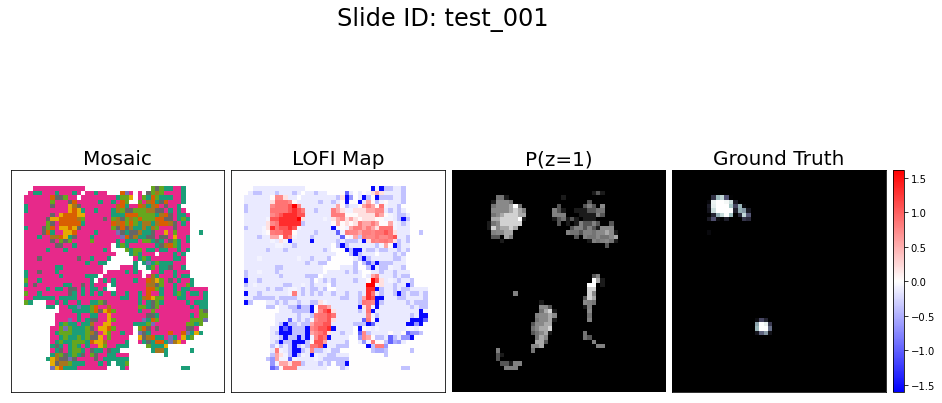

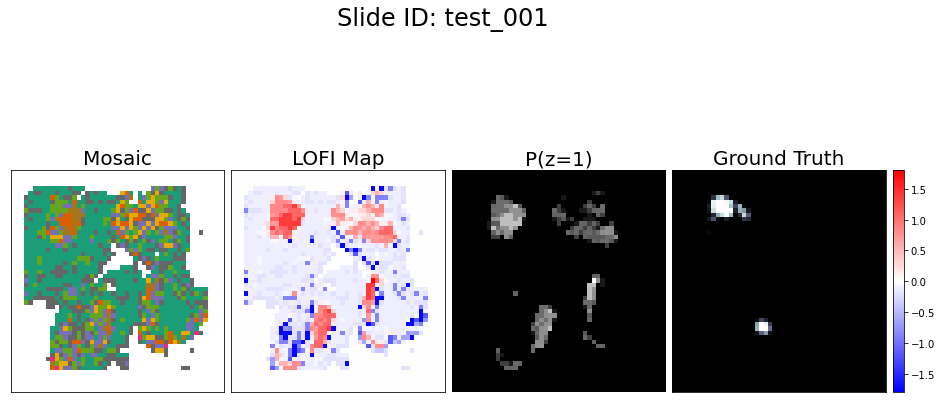

In [264]:
from embed_patches import lofi_map, sod_map_generator
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/test_crop_coords.obj")
Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_001.npy"
gt_path = "/home/data/tinycam/test/gt_masks/test_001_gt.npy"

for best_model in [best_detok_accso, best_detok_accfg]:
    Kb = best_model["K"]
    rb = best_model["r"]
    ab = best_model["a"]
    tb = best_model["t"]
    [class0_tfidf, class1_tfidf, pvals] = tfidfs[(Kb,rb)]
    kmeans = kmeans_models[Kb]
    log2fc, neglog10p, colors = diff_exp(tfidfs, Kb, rb, tau=tb, alpha=ab)        
    significance_mask = [0 if c=="gray" else 1 for c in colors]
    FI = log2fc * np.array(significance_mask)
    M = lofi_map(Z_path, kmeans, FI=FI, mode="clusterbag", nbhd_size=rb)
    C_crop, zero_id, M_crop, normalized, mask = sod_map_generator(Z_path, M, kmeans, crop_dict, nbhd_size=rb, mask_path=gt_path, highres_flag=False)

In [255]:
print(list(best_elastic_auprc.index))
print(list(best_elastic_auprc))
print(list(best_elastic_accso))
print(list(best_elastic_accfg))

['K', 'r', 'model_class', 'a', 't', 'auroc', 'auprc', 'acc_fg', 'acc_so']
[25, 0, 'elastic', nan, nan, 0.5760204081632654, 0.6746696951606689, 0.8629206609090632, 0.31433689599285713]
[30, 2, 'elastic', nan, nan, 0.577295918367347, 0.4766498043697644, 0.8628998205981778, 0.4409339099238594]
[15, 1, 'elastic', nan, nan, 0.5783163265306123, 0.521034822163476, 0.8736487478290188, 0.4209301460831761]


mask shape: (2800, 2688)
map shape:  (51, 49)
mask shape: (51, 49)
mask shape: (2800, 2688)
map shape:  (51, 49)
mask shape: (51, 49)


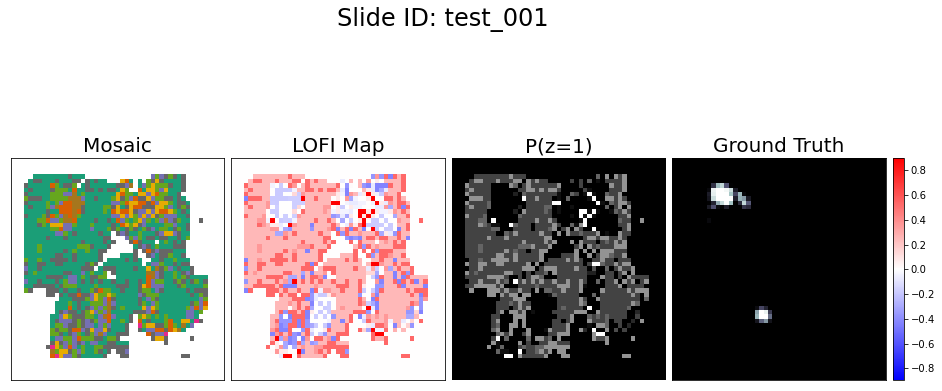

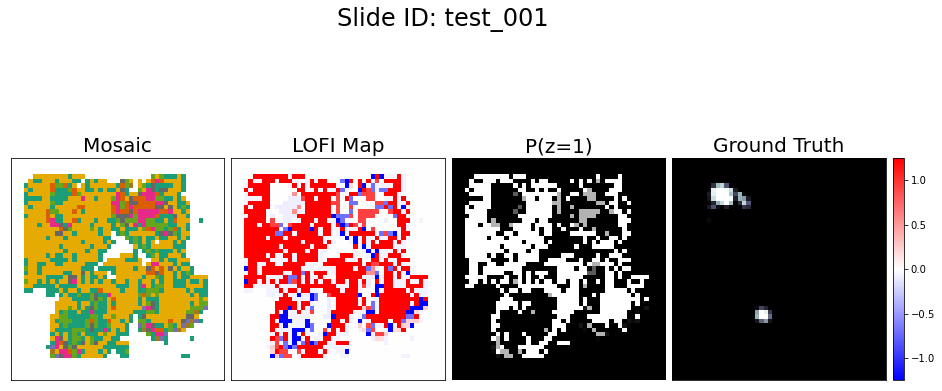

In [251]:
from embed_patches import lofi_map, sod_map_generator
crop_dict = deserialize("/home/codex_analysis/codex-analysis/code/test_crop_coords.obj")
Z_path = "/home/data/tinycam/test/clean_Zs/Z-test_001.npy"
gt_path = "/home/data/tinycam/test/gt_masks/test_001_gt.npy"

for best_model in [best_elastic_accso, best_elastic_accfg]:
    Kb = best_model["K"]
    rb = best_model["r"]
    FI, _, _ = elastic[(Kb,rb)]
    kmeans = kmeans_models[Kb]
    M = lofi_map(Z_path, kmeans, FI=FI, mode="clusterbag", nbhd_size=rb)
    C_crop, zero_id, M_crop, normalized, mask = sod_map_generator(Z_path, M, kmeans, crop_dict, nbhd_size=rb, mask_path=gt_path, highres_flag=False)